In [1]:
import pandas as pd
import random
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torchaudio
from torchaudio import transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

## Работу выполнил Усольцев Никита.
https://t.me/usoltsev37

## Предобработка данных.

Предобработка происходит в два этапа:

1. Обрезаем длину аудио до ```max_seconds = 5```
2. Переводим сигнал в спектрограмму

Константа ```max_seconds = 5``` потому что это что-то оно близко
к медианам на датасетах "test-clean.csv" и "dev-clean.csv"

```
>> test-clean
median - 4.849833333333334

>>  dev-clean
median - 4.41
```

Перевожу в спектрограмму, потому что спектрограмма содержит много структурированной информации
о сигнале, после гугления методов классификации звука остановился на спектрограммах

In [2]:
#
# Convert the signal to a fixed size 'max_seconds'
#
# @params
#   'audio' - audio signal consists of (signal, sampling rate)
#   'max_seconds'- fixed size of the signal
# @return transforms.MelSpectrogram
#
def crop_signal(audio: tuple, max_seconds: int):
    sig, sr = audio
    max_width = sr * max_seconds
    sig_height, sig_width = sig.shape

    if sig_width > max_width:
        sig = sig[:,:max_width]
    elif sig_width < max_width:
        pad_start_width = random.randint(0, max_width - sig_width)
        pad_end_width = max_width - sig_width - pad_start_width
        sig = torch.cat((torch.zeros((sig_height, pad_start_width)),
                         sig,
                         torch.zeros((sig_height, pad_end_width))), 1)

    return sig, sr

In [3]:
#
# Create DB Spectrogram
#
# @params
#   'audio' - audio signal consists of (signal, sampling rate)
#   'n_mels' - number of mel filterbanks
#   'n_fft' - size of FFT
#   'hop_len' - length of hop between STFT windows
# @return transforms.MelSpectrogram
#
def create_db_spectrogram(aud, n_mels=64, n_fft=1024, hop_len=None):
    sig, sr = aud
    spec = transforms.MelSpectrogram(sr, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels)(sig)
    spec = transforms.AmplitudeToDB(top_db=120)(spec)
    return spec

In [4]:
#
# Dataset for classification
#
class TaskDataset(Dataset):
    def __init__(self, df, data_path: str):
        self.df = df
        self.data_path = data_path
        self.max_seconds = 5
        self.sr = 24000

    #
    # Number of items in dataset
    # @return int
    #
    def __len__(self):
        return len(self.df)

    #
    # Get item from dataset by index
    #
    # @params
    #   idx - index of item in dataset
    # @return Tuple[spec, gender]
    #   spec - transforms.MelSpectrogram (shape=[1, 64, time_series])
    #   gender - target (0 or 1)
    #
    def __getitem__(self, idx):
        audio_file_path = self.data_path + self.df.loc[idx, 'PATH_TO_FILE']
        audio = torchaudio.load(audio_file_path)
        gender = self.df.loc[idx, 'GENDER']

        # Preprocessing
        dur_aud = crop_signal(audio, self.max_seconds)
        spec = create_db_spectrogram(dur_aud, n_mels=64, n_fft=1024, hop_len=512)

        return spec, gender



## Подготовка DataLoader для training и inference.

В качестве ```train``` датасета я взял "dev-clean.csv" из LibriTTS, он сбалансирован ко классам.

В качестве ```val``` и ```test``` датасетов я взял "test-clean.csv" из LibriTTS,
предварительное разделив его на две равные части. ```val``` и ```test``` сбалансированные по полу.

In [5]:
df_train = pd.read_csv('train-dev-clean.csv', sep=';')
data_path = '/Users/thebest/interview/huawei/huawei-gender-classifier/'
df_train.head()

,PATH_TO_FILE,GENDER
0,LibriTTS/dev-clean/2412/153954/2412_153954_000...,0
1,LibriTTS/dev-clean/2412/153954/2412_153954_000...,0
2,LibriTTS/dev-clean/2412/153954/2412_153954_000...,0
3,LibriTTS/dev-clean/2412/153954/2412_153954_000...,0
4,LibriTTS/dev-clean/2412/153954/2412_153954_000...,0


In [6]:
ds_train = TaskDataset(df_train, data_path)
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=16, shuffle=True)

In [7]:
df_test = pd.read_csv('test-test-clean.csv', sep=';')
df_test.head()


,PATH_TO_FILE,GENDER
0,LibriTTS/test-clean/6829/68769/6829_68769_0000...,0
1,LibriTTS/test-clean/6829/68769/6829_68769_0000...,0
2,LibriTTS/test-clean/6829/68769/6829_68769_0000...,0
3,LibriTTS/test-clean/6829/68769/6829_68769_0000...,0
4,LibriTTS/test-clean/6829/68769/6829_68769_0000...,0


In [8]:
ds_test = TaskDataset(df_test, data_path)
dl_test = torch.utils.data.DataLoader(ds_test, batch_size=16, shuffle=True)

In [9]:
df_val = pd.read_csv('val-test-clean.csv', sep=';')
df_val.head()

,PATH_TO_FILE,GENDER
0,LibriTTS/test-clean/61/70970/61_70970_000007_0...,1
1,LibriTTS/test-clean/5639/40744/5639_40744_0000...,1
2,LibriTTS/test-clean/5639/40744/5639_40744_0000...,1
3,LibriTTS/test-clean/5639/40744/5639_40744_0000...,1
4,LibriTTS/test-clean/5639/40744/5639_40744_0000...,1


In [10]:
ds_val = TaskDataset(df_val, data_path)
dl_val = torch.utils.data.DataLoader(ds_val, batch_size=16, shuffle=True)

## Архитектура Нейронной сети:

Выбрал CNN архитектуру, потому что мы работаем со спектрограммами - то есть тензорами.

Нашел пример применения CNN Encoder архитектуры для классификации аудио,
но там классификация более сложнее, а не просто на два пола.
https://paperswithcode.com/paper/leaf-a-learnable-frontend-for-audio

Сама архитектура почти полностью скопирована
из этой статьи http://ceur-ws.org/Vol-1609/16090547.pdf.
Она написана по результатам соревнования на классификацию птичего щебета
(1000 классов птиц).

Единтсвенное отличие добавление второго полносвязного слоя в конец ```self.lin2```
(не проводил эксперемент по сравнению - дает ли это улучшение,
просто хотел сгладить переход размерностей как в LeNet-5)


In [11]:
#
# Classification Model
#
class CNNClassifier (nn.Module):

    def __init__(self):
        super().__init__()
        conv_layers = []
        kernel_size_conv = (5, 5)
        stride_conv = (1, 1)
        padding_conv =(2, 2)
        
        kernel_size_pool = (2, 2)
        stride_pool = (2, 2)
        
        # 1 Convolution Block with Relu. 
        self.conv1 = nn.Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 3), padding=(2, 3))
        self.relu1 = nn.ReLU()
        self.mp1 = nn.MaxPool2d(kernel_size=kernel_size_pool, stride=stride_pool)
        self.bn1 = nn.BatchNorm2d(16)
        self.dp1 = nn.Dropout(0.2)
        nn.init.xavier_uniform_(self.conv1.weight)
        self.conv1.bias.data.zero_()
        conv_layers += [self.conv1, self.relu1, self.mp1, self.dp1, self.bn1]

        # 2 Convolution Block
        self.conv2 = nn.Conv2d(16, 32, kernel_size=kernel_size_conv, stride=stride_conv, padding=padding_conv)
        self.relu2 = nn.ReLU()
        self.mp2 = nn.MaxPool2d(kernel_size=kernel_size_pool, stride=stride_pool)
        self.bn2 = nn.BatchNorm2d(32)
        nn.init.xavier_uniform_(self.conv2.weight)
        self.conv2.bias.data.zero_()
        conv_layers += [self.conv2, self.relu2, self.mp2, self.bn2]
        
        # 3 Convolution Block
        self.conv3 = nn.Conv2d(32, 64, kernel_size=kernel_size_conv, stride=stride_conv, padding=padding_conv)
        self.relu3 = nn.ReLU()
        self.mp3 = nn.MaxPool2d(kernel_size=kernel_size_pool, stride=stride_pool)
        self.bn3 = nn.BatchNorm2d(64)
        nn.init.xavier_uniform_(self.conv3.weight)
        self.conv3.bias.data.zero_()
        conv_layers += [self.conv3, self.relu3, self.mp3, self.bn3]

        # 4 Convolution Block
        self.conv4 = nn.Conv2d(64, 128, kernel_size=kernel_size_conv, stride=stride_conv, padding=padding_conv)
        self.relu4 = nn.ReLU()
        self.mp4 = nn.AvgPool2d(kernel_size=kernel_size_pool, stride=stride_pool)
        self.bn4 = nn.BatchNorm2d(128)
        nn.init.xavier_uniform_(self.conv4.weight)
        self.conv4.bias.data.zero_()
        conv_layers += [self.conv4, self.relu4, self.mp4, self.bn4]
        
        # 5 Convolution Block
        self.conv5 = nn.Conv2d(128, 128, kernel_size=kernel_size_conv, stride=stride_conv, padding=padding_conv)
        self.relu5 = nn.ReLU()
        self.mp5 = nn.MaxPool2d(kernel_size=kernel_size_pool, stride=stride_pool)
        self.bn5 = nn.BatchNorm2d(128)
        nn.init.xavier_uniform_(self.conv5.weight)
        self.conv5.bias.data.zero_()
        conv_layers += [self.conv5, self.relu5, self.mp5, self.bn5]

        self.convs = nn.Sequential(*conv_layers)
        
        # Linear Layers
        self.lin1 = nn.Linear(in_features=512, out_features=128)
        self.lin2 = nn.Linear(in_features=128, out_features=2)

        # Dropout Layers
        self.dp2 = nn.Dropout(0.4)
        self.dp3 = nn.Dropout(0.4)

        # Softmax Layer
        self.sm = nn.Softmax(dim=1)
 
    #
    # Forward pass
    #
    def forward(self, x):
        # Convs Layers
        x = self.convs(x)

        x = x.view((x.shape[0], 512))

        # Linear Layer 1
        x = self.lin1(x)
        x = self.dp2(x)

        # Linear Layer 2
        x = self.lin2(x)
        x = self.dp3(x)

        # Softmax Layer
        x = self.sm(x)
        return x

In [12]:
model = CNNClassifier()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
device

device(type='cpu')

In [13]:
#
# Train
#
def train(model, train_dl, val_dl, num_epochs, lr=0.001):
    # Loss Function, Optimizer and Scheduler
    CELoss = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=lr)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr,
                                                steps_per_epoch=int(len(train_dl)),
                                                epochs=num_epochs,
                                                anneal_strategy='linear')
    train_loses = []
    val_loses = []
    train_acc = []
    val_acc = []
    
    def plot_learning():
        plt.figure(figsize=(12, 6))
        plt.title('Loss')
        plt.plot(range(len(train_loses)), train_loses, label='train')
        plt.plot(range(len(val_loses)), val_loses, label='val')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.tight_layout()
        plt.show()
        
        plt.figure(figsize=(12, 6))
        plt.title('Accuracy')
        plt.plot(range(len(train_acc)), train_acc, label='train')
        plt.plot(range(len(val_acc)), val_acc, label='val')
        plt.xlabel('Epoch')
        plt.ylabel('Acc')
        plt.legend()
        plt.tight_layout()
        plt.show()
        
    
    def run_epoch(is_validate: bool, dl, l_loses, l_acc, log_mode: str):
        running_loss = 0.0
        right_predictions = 0
        all_predictions = 0

        for i, data in enumerate(dl):
            inputs, labels = data[0].to(device), data[1].to(device)

            # Normalize because of BatchNorm layers in model
            inputs_m, inputs_s = inputs.mean(), inputs.std()
            inputs = (inputs - inputs_m) / inputs_s
            
            
            # Zero the parameter gradients
            if not is_validate:
                optimizer.zero_grad()

            # forward
            outputs = model(inputs)
            loss = CELoss(outputs, labels)

            if not is_validate:
                # backward + optimize
                loss.backward()
                optimizer.step()
                scheduler.step()

            running_loss += loss.item()
            _, prediction = torch.max(outputs,1)
            
            right_predictions += (prediction == labels).sum().item()
            all_predictions += prediction.shape[0]

        num_batches = len(dl)
        curr_loss = running_loss / num_batches
        accuracy = right_predictions / all_predictions
        l_loses.append(curr_loss)
        l_acc.append(accuracy)
        return f'{log_mode}: Epoch: {epoch}, Loss: {curr_loss:.2f}, Accuracy: {accuracy:.2f}'



    for epoch in tqdm(range(num_epochs)):
        log_train = run_epoch(is_validate=False, dl=train_dl, l_loses=train_loses, l_acc=train_acc, log_mode='TRAIN')
        with torch.no_grad(): 
            log_val = run_epoch(is_validate=True, dl=val_dl, l_loses=val_loses, l_acc=val_acc, log_mode='VAL')
        print('\t' + log_train)
        print(log_val)
        
    print('Finished Training')
    plot_learning()
  

 10%|█         | 1/10 [01:11<10:46, 71.78s/it]

	TRAIN: Epoch: 0, Loss: 0.52, Accuracy: 0.77
VAL: Epoch: 0, Loss: 0.43, Accuracy: 0.89


 20%|██        | 2/10 [02:13<08:47, 65.97s/it]

	TRAIN: Epoch: 1, Loss: 0.46, Accuracy: 0.84
VAL: Epoch: 1, Loss: 0.41, Accuracy: 0.90


 30%|███       | 3/10 [03:20<07:44, 66.37s/it]

	TRAIN: Epoch: 2, Loss: 0.46, Accuracy: 0.84
VAL: Epoch: 2, Loss: 0.40, Accuracy: 0.91


 40%|████      | 4/10 [04:20<06:24, 64.01s/it]

	TRAIN: Epoch: 3, Loss: 0.45, Accuracy: 0.85
VAL: Epoch: 3, Loss: 0.42, Accuracy: 0.90


 50%|█████     | 5/10 [05:22<05:14, 62.96s/it]

	TRAIN: Epoch: 4, Loss: 0.46, Accuracy: 0.83
VAL: Epoch: 4, Loss: 0.41, Accuracy: 0.90


 60%|██████    | 6/10 [06:21<04:06, 61.62s/it]

	TRAIN: Epoch: 5, Loss: 0.44, Accuracy: 0.86
VAL: Epoch: 5, Loss: 0.46, Accuracy: 0.85


 70%|███████   | 7/10 [07:19<03:01, 60.63s/it]

	TRAIN: Epoch: 6, Loss: 0.44, Accuracy: 0.86
VAL: Epoch: 6, Loss: 0.42, Accuracy: 0.88


 80%|████████  | 8/10 [08:15<01:58, 59.22s/it]

	TRAIN: Epoch: 7, Loss: 0.43, Accuracy: 0.86
VAL: Epoch: 7, Loss: 0.44, Accuracy: 0.86


 90%|█████████ | 9/10 [09:10<00:57, 57.85s/it]

	TRAIN: Epoch: 8, Loss: 0.42, Accuracy: 0.87
VAL: Epoch: 8, Loss: 0.43, Accuracy: 0.89


100%|██████████| 10/10 [10:06<00:00, 60.65s/it]

	TRAIN: Epoch: 9, Loss: 0.42, Accuracy: 0.88
VAL: Epoch: 9, Loss: 0.46, Accuracy: 0.85
Finished Training


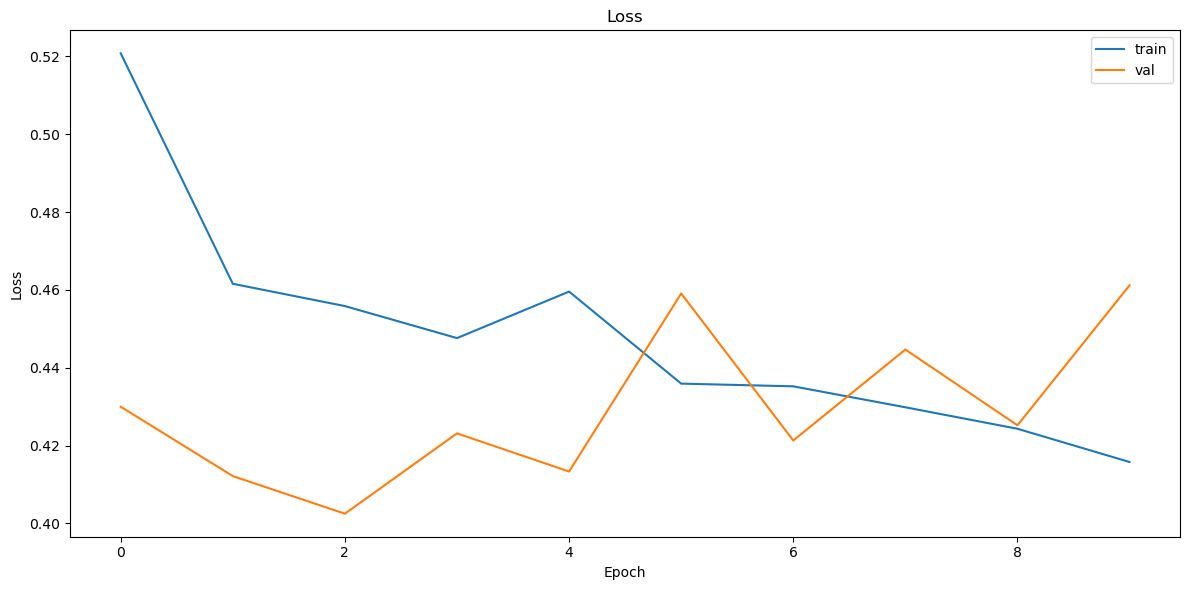

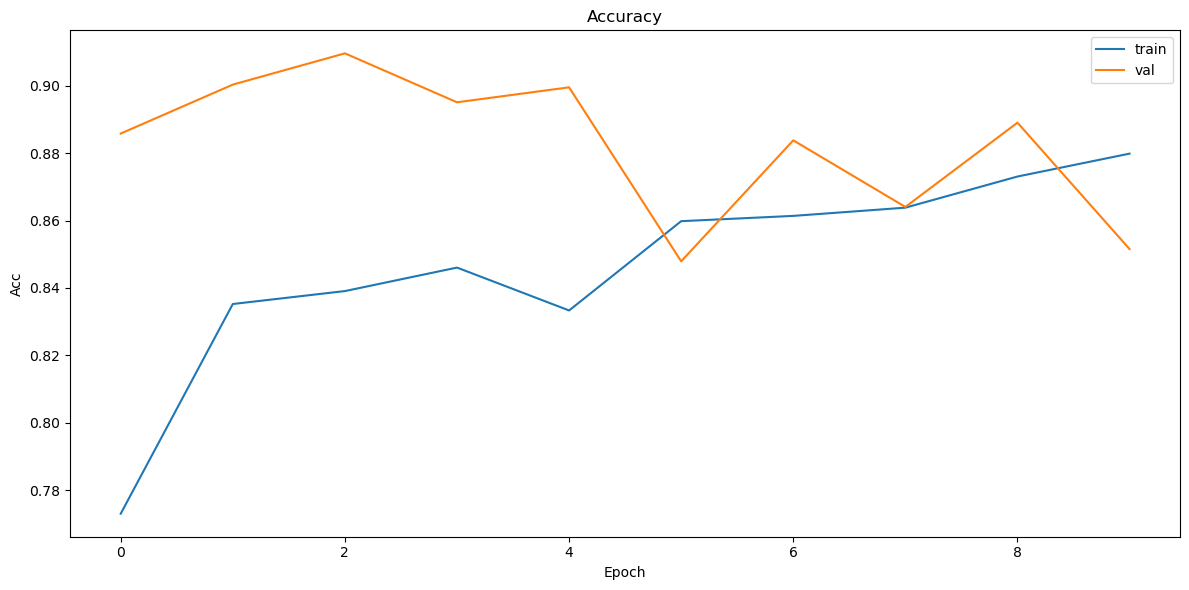

In [14]:
num_epochs=10
train(model, dl_train, dl_val, num_epochs)

In [15]:
#
# Inference
#
def inference (model, dl):
    right_predictions = 0
    all_predictions = 0
    true_positive = 0
    false_positive = 0
    false_negative = 0

    with torch.no_grad():
        for data in dl:
            inputs, labels = data[0].to(device), data[1].to(device)

            inputs_m, inputs_s = inputs.mean(), inputs.std()
            inputs = (inputs - inputs_m) / inputs_s

            outputs = model(inputs)
            _, prediction = torch.max(outputs,1)

            true_positive += (np.logical_and(labels == True, prediction == True)).sum().item()
            false_positive += (np.logical_and(labels == False, prediction == True)).sum().item()
            false_negative += (np.logical_and(labels == True, prediction == False)).sum().item()
            right_predictions += (prediction == labels).sum().item()
            all_predictions += prediction.shape[0]
    
    precision = true_positive / (true_positive + false_positive)
    recall = true_positive / (true_positive + false_negative)
    accuracy = right_predictions / all_predictions

    print(f'Accuracy: {accuracy:.2f}, Total items: {all_predictions}')
    print(f'Precision: {precision}, Recall: {recall}')

In [16]:
inference(model, dl_test)



Accuracy: 0.84, Total items: 2358
Precision: 0.8286985539488321, Recall: 0.7768508863399375


In [17]:
torch.save(model.state_dict(), '/Users/thebest/interview/huawei/huawei-gender-classifier/model01')

## Метрики качества модели:

Классика для бинарной классификации:

1. Accuracy
2. Precision
3. Recall

## Результаты:

Маленькое число эпох, поэтому не понятно как себя будет вести оранжевый график
дальше, может быть дальше он будет падать на loss и расти на метрики вместе
с голубой линей и Early stopping (та эпоха на которой у нас
графики пересеклись - значит, что мы начинаем переобучаться
и нужно останавливать обучение, для этого и нужна
валидационная выборка) стоит сделать позже (а не на 2-3 эпохе).

Еще может быть проблема в оптимизации, плохо подобрана
скорость обучения в градиентном спуске или плохое расписание.

Еще есть гипотеза, что предложенная архитектура большая для такого датасета и задачи.

В целом неплохой классификатор, он лучше рандома


## Предложения по улучшению:

### Что можно улучшить:
1. Аугентировать датасет для обучения (например двигать сигналы)
2. Подобрать лучшие параметры для формирования Mel Spectogram
(если задач менее игрушечная, то для начала эти параметры берутся
из прошлых исследование - если исследование нет, то проводят свои
эксперименты)
3. Еще можно попробывать использовать MFCC, а не Mel Spectogram
(на towardsdatascience прочитал, что она лучше подходит для
работы с человеческим голосом)

Давайте попробуем реализовать последний шаг

### Архитекрутрные улучшения - "гипотезы для эксперементов":

1. Потренировать на большем числе эпох (в исходной статье 1000 эпох), чтобы
достичь переобучения на ```val``` и определить оптимальное число эпох для обучения(и сделать Early stopping)
2. Dropout - подобрать более оптимальный параметр в Dropout для такого размера задачи
3. Добавил бы помимо MaxPool2d, еще и AvgPool2d
4. Найти оптимальные параметры для оптимизации, например grip_search
5. Уменьшить глубину нейронной сети

Очевидно, что увеличение размера batch и количество каналов между
сверточными слоями - улучшит качество модели, но при это возрастут ресурсы на обучение

## Эксперемент 02 - MFCC вместо Mel Spectogram

In [18]:
#
# Create MFCC Spectrogram
#
# @params
#   'audio' - audio signal consists of (signal, sampling rate)
#   'n_mels' - number of mel filterbanks
#   'n_fft' - size of FFT
#   'hop_len' - length of hop between STFT windows
# @return transforms.MFCC
#
def create_db_MFCC_spectrogram(aud, n_mels=64, n_fft=1024, hop_length=None):
    sig, sr = aud
    spec  = transforms.MFCC(
        sample_rate=sr,
        n_mfcc=40,
        melkwargs={
            "n_fft": n_fft,
            "n_mels": n_mels,
            "hop_length": hop_length,
            "mel_scale": "htk",
        },
    )(sig)

    return spec

In [19]:
#
# Dataset for classification
#
class TaskDatasetMFCC(Dataset):
    def __init__(self, df, data_path: str):
        self.df = df
        self.data_path = data_path
        self.max_seconds = 5
        self.sr = 24000

    #
    # Number of items in dataset
    # @return int
    #
    def __len__(self):
        return len(self.df)

    #
    # Get item from dataset by index
    #
    # @params
    #   idx - index of item in dataset
    # @return Tuple[spec, gender]
    #   spec - transforms.MelSpectrogram (shape=[1, 64, time_series])
    #   gender - target (0 or 1)
    #
    def __getitem__(self, idx):
        audio_file_path = self.data_path + self.df.loc[idx, 'PATH_TO_FILE']
        audio = torchaudio.load(audio_file_path)
        gender = self.df.loc[idx, 'GENDER']

        # Preprocessing
        dur_aud = crop_signal(audio, self.max_seconds)
        # MFCC !!!
        spec = create_db_MFCC_spectrogram(dur_aud, n_mels=64, n_fft=1024, hop_length=512)

        return spec, gender


In [20]:
df_train = pd.read_csv('train-dev-clean.csv', sep=';')
data_path = '/Users/thebest/interview/huawei/huawei-gender-classifier/'
df_train.head()

ds_train = TaskDatasetMFCC(df_train, data_path)
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=16, shuffle=True)

In [21]:
df_test = pd.read_csv('test-test-clean.csv', sep=';')
df_test.head()


ds_test = TaskDatasetMFCC(df_test, data_path)
dl_test = torch.utils.data.DataLoader(ds_test, batch_size=16, shuffle=True)

In [22]:
df_val = pd.read_csv('val-test-clean.csv', sep=';')
df_val.head()


ds_val = TaskDatasetMFCC(df_val, data_path)
dl_val = torch.utils.data.DataLoader(ds_val, batch_size=16, shuffle=True)

In [23]:

#
# Classification Model for MFCC (change dimension in self.lin1 from 512 to 256)
#
class CNNClassifier2 (nn.Module):

    def __init__(self):
        super().__init__()
        conv_layers = []
        kernel_size_conv = (5, 5)
        stride_conv = (1, 1)
        padding_conv =(2, 2)

        kernel_size_pool = (2, 2)
        stride_pool = (2, 2)

        # 1 Convolution Block with Relu.
        self.conv1 = nn.Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 3), padding=(2, 3))
        self.relu1 = nn.ReLU()
        self.mp1 = nn.MaxPool2d(kernel_size=kernel_size_pool, stride=stride_pool)
        self.bn1 = nn.BatchNorm2d(16)
        self.dp1 = nn.Dropout(0.2)
        nn.init.xavier_uniform_(self.conv1.weight)
        self.conv1.bias.data.zero_()
        conv_layers += [self.conv1, self.relu1, self.mp1, self.dp1, self.bn1]

        # 2 Convolution Block
        self.conv2 = nn.Conv2d(16, 32, kernel_size=kernel_size_conv, stride=stride_conv, padding=padding_conv)
        self.relu2 = nn.ReLU()
        self.mp2 = nn.MaxPool2d(kernel_size=kernel_size_pool, stride=stride_pool)
        self.bn2 = nn.BatchNorm2d(32)
        nn.init.xavier_uniform_(self.conv2.weight)
        self.conv2.bias.data.zero_()
        conv_layers += [self.conv2, self.relu2, self.mp2, self.bn2]

        # 3 Convolution Block
        self.conv3 = nn.Conv2d(32, 64, kernel_size=kernel_size_conv, stride=stride_conv, padding=padding_conv)
        self.relu3 = nn.ReLU()
        self.mp3 = nn.MaxPool2d(kernel_size=kernel_size_pool, stride=stride_pool)
        self.bn3 = nn.BatchNorm2d(64)
        nn.init.xavier_uniform_(self.conv3.weight)
        self.conv3.bias.data.zero_()
        conv_layers += [self.conv3, self.relu3, self.mp3, self.bn3]

        # 4 Convolution Block
        self.conv4 = nn.Conv2d(64, 128, kernel_size=kernel_size_conv, stride=stride_conv, padding=padding_conv)
        self.relu4 = nn.ReLU()
        self.mp4 = nn.AvgPool2d(kernel_size=kernel_size_pool, stride=stride_pool)
        self.bn4 = nn.BatchNorm2d(128)
        nn.init.xavier_uniform_(self.conv4.weight)
        self.conv4.bias.data.zero_()
        conv_layers += [self.conv4, self.relu4, self.mp4, self.bn4]

        # 5 Convolution Block
        self.conv5 = nn.Conv2d(128, 128, kernel_size=kernel_size_conv, stride=stride_conv, padding=padding_conv)
        self.relu5 = nn.ReLU()
        self.mp5 = nn.MaxPool2d(kernel_size=kernel_size_pool, stride=stride_pool)
        self.bn5 = nn.BatchNorm2d(128)
        nn.init.xavier_uniform_(self.conv5.weight)
        self.conv5.bias.data.zero_()
        conv_layers += [self.conv5, self.relu5, self.mp5, self.bn5]

        self.convs = nn.Sequential(*conv_layers)

        # Linear Layers
        self.lin1 = nn.Linear(in_features=256, out_features=128)
        self.lin2 = nn.Linear(in_features=128, out_features=2)

        # Dropout Layers
        self.dp2 = nn.Dropout(0.4)
        self.dp3 = nn.Dropout(0.4)

        # Softmax Layer
        self.sm = nn.Softmax(dim=1)

    #
    # Forward pass
    #
    def forward(self, x):
        # Convs Layers
        x = self.convs(x)

        x = x.view((x.shape[0], 256))

        # Linear Layer 1
        x = self.lin1(x)
        x = self.dp2(x)

        # Linear Layer 2
        x = self.lin2(x)
        x = self.dp3(x)

        # Softmax Layer
        x = self.sm(x)
        return x


In [24]:
model2 = CNNClassifier2()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model2 = model2.to(device)

 33%|███▎      | 1/3 [00:47<01:35, 47.82s/it]

	TRAIN: Epoch: 0, Loss: 0.50, Accuracy: 0.80
VAL: Epoch: 0, Loss: 0.45, Accuracy: 0.86


 67%|██████▋   | 2/3 [01:35<00:47, 47.64s/it]

	TRAIN: Epoch: 1, Loss: 0.45, Accuracy: 0.85
VAL: Epoch: 1, Loss: 0.43, Accuracy: 0.89


100%|██████████| 3/3 [02:23<00:00, 47.75s/it]

	TRAIN: Epoch: 2, Loss: 0.44, Accuracy: 0.85
VAL: Epoch: 2, Loss: 0.44, Accuracy: 0.88
Finished Training


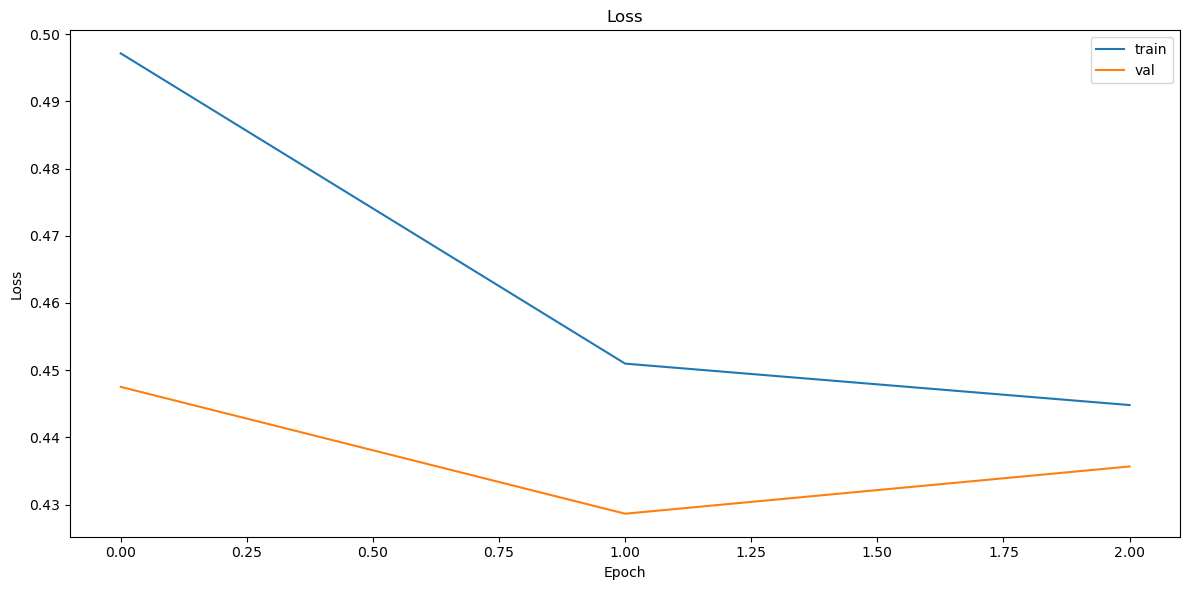

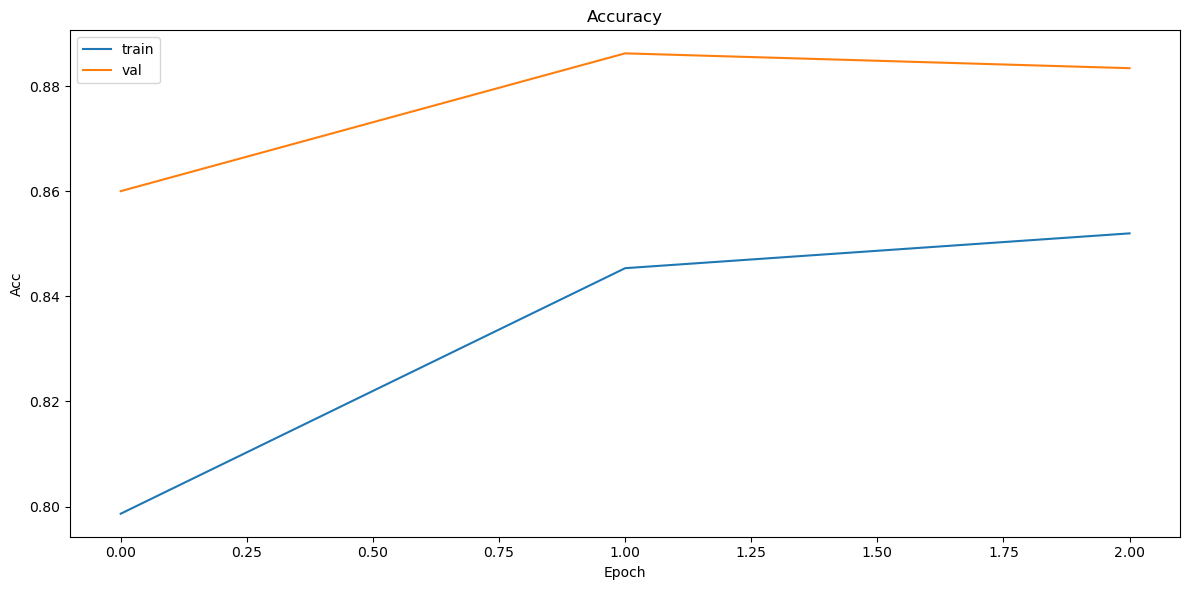

In [25]:
num_epochs=3
train(model2, dl_train, dl_val, num_epochs)

In [26]:
inference(model2, dl_test)


Accuracy: 0.86, Total items: 2358
Precision: 0.8748510131108462, Recall: 0.7653806047966631


 10%|█         | 1/10 [00:48<07:12, 48.09s/it]

	TRAIN: Epoch: 0, Loss: 0.50, Accuracy: 0.80
VAL: Epoch: 0, Loss: 0.50, Accuracy: 0.80


 20%|██        | 2/10 [01:35<06:21, 47.74s/it]

	TRAIN: Epoch: 1, Loss: 0.46, Accuracy: 0.83
VAL: Epoch: 1, Loss: 0.44, Accuracy: 0.86


 30%|███       | 3/10 [02:23<05:35, 47.90s/it]

	TRAIN: Epoch: 2, Loss: 0.46, Accuracy: 0.84
VAL: Epoch: 2, Loss: 0.52, Accuracy: 0.80


 40%|████      | 4/10 [03:15<04:55, 49.32s/it]

	TRAIN: Epoch: 3, Loss: 0.43, Accuracy: 0.86
VAL: Epoch: 3, Loss: 0.47, Accuracy: 0.84


 50%|█████     | 5/10 [04:06<04:10, 50.07s/it]

	TRAIN: Epoch: 4, Loss: 0.41, Accuracy: 0.89
VAL: Epoch: 4, Loss: 0.49, Accuracy: 0.82


 60%|██████    | 6/10 [04:56<03:20, 50.01s/it]

	TRAIN: Epoch: 5, Loss: 0.40, Accuracy: 0.89
VAL: Epoch: 5, Loss: 0.52, Accuracy: 0.79


 70%|███████   | 7/10 [05:45<02:28, 49.54s/it]

	TRAIN: Epoch: 6, Loss: 0.39, Accuracy: 0.91
VAL: Epoch: 6, Loss: 0.50, Accuracy: 0.81


 80%|████████  | 8/10 [06:35<01:39, 49.86s/it]

	TRAIN: Epoch: 7, Loss: 0.39, Accuracy: 0.91
VAL: Epoch: 7, Loss: 0.44, Accuracy: 0.87


 90%|█████████ | 9/10 [07:29<00:50, 50.98s/it]

	TRAIN: Epoch: 8, Loss: 0.39, Accuracy: 0.91
VAL: Epoch: 8, Loss: 0.47, Accuracy: 0.84


100%|██████████| 10/10 [08:18<00:00, 49.86s/it]

	TRAIN: Epoch: 9, Loss: 0.38, Accuracy: 0.91
VAL: Epoch: 9, Loss: 0.47, Accuracy: 0.85
Finished Training


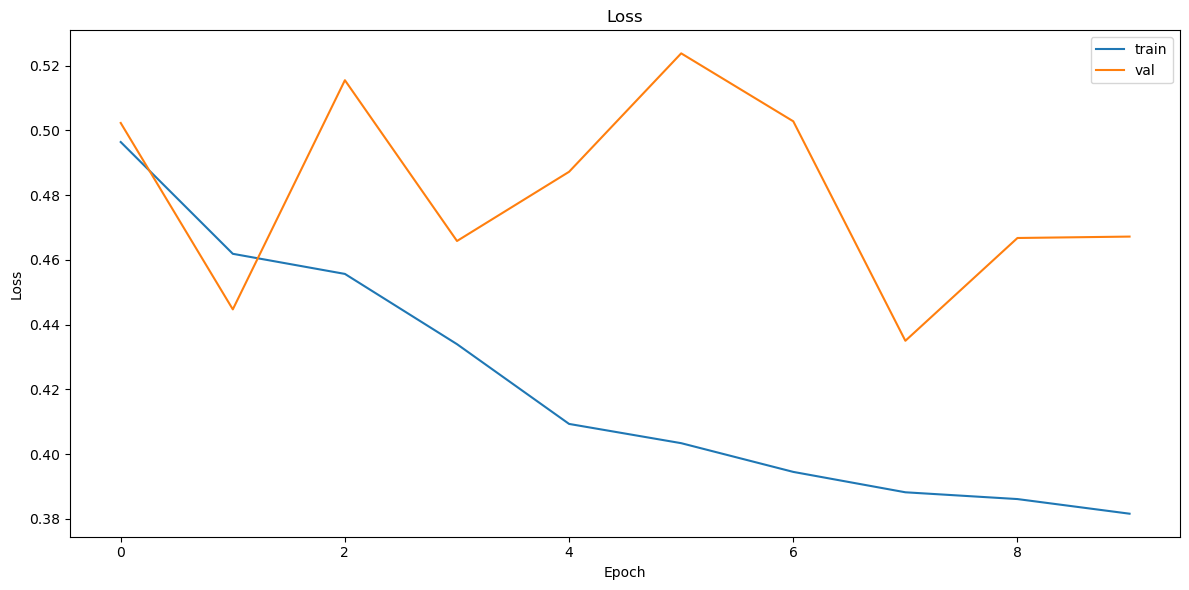

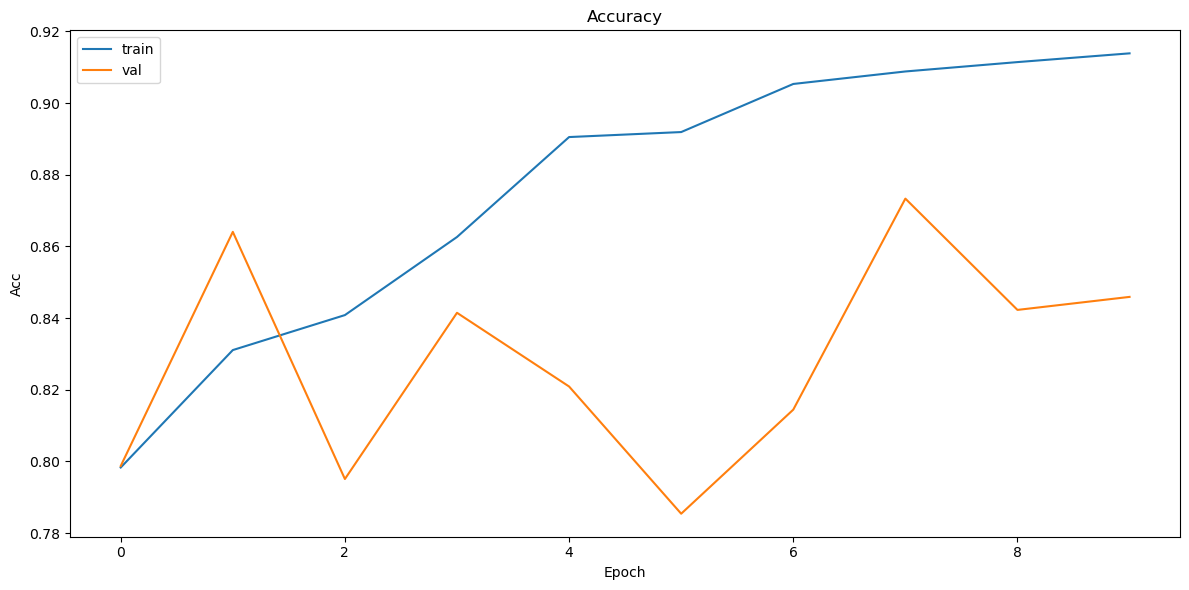

In [27]:
model3 = CNNClassifier2()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model3 = model3.to(device)

num_epochs=10
train(model3, dl_train, dl_val, num_epochs)

In [28]:
inference(model3, dl_test)

Accuracy: 0.87, Total items: 2358
Precision: 0.8686296715741789, Recall: 0.799791449426486


## Результат - Эксперемент 02

MFCC не улучшает результат по сравнению Mel Spectogram, но может
быть ситуация измениться, если тренировать обе на большем числе эпох

## Эксперемент 03 - Увеличим скорость обучения ```lr``` c 0.001 до 0.005 и уберем расписание

 10%|█         | 1/10 [00:58<08:45, 58.34s/it]

	TRAIN: Epoch: 0, Loss: 0.55, Accuracy: 0.75
VAL: Epoch: 0, Loss: 0.59, Accuracy: 0.72


 20%|██        | 2/10 [01:59<08:00, 60.02s/it]

	TRAIN: Epoch: 1, Loss: 0.60, Accuracy: 0.70
VAL: Epoch: 1, Loss: 0.51, Accuracy: 0.80


 30%|███       | 3/10 [02:55<06:46, 58.13s/it]

	TRAIN: Epoch: 2, Loss: 0.55, Accuracy: 0.74
VAL: Epoch: 2, Loss: 0.48, Accuracy: 0.83


 40%|████      | 4/10 [03:49<05:38, 56.36s/it]

	TRAIN: Epoch: 3, Loss: 0.55, Accuracy: 0.74
VAL: Epoch: 3, Loss: 0.47, Accuracy: 0.84


 50%|█████     | 5/10 [04:43<04:37, 55.53s/it]

	TRAIN: Epoch: 4, Loss: 0.51, Accuracy: 0.79
VAL: Epoch: 4, Loss: 0.53, Accuracy: 0.79


 60%|██████    | 6/10 [05:35<03:37, 54.46s/it]

	TRAIN: Epoch: 5, Loss: 0.54, Accuracy: 0.76
VAL: Epoch: 5, Loss: 0.55, Accuracy: 0.76


 70%|███████   | 7/10 [06:27<02:41, 53.74s/it]

	TRAIN: Epoch: 6, Loss: 0.52, Accuracy: 0.77
VAL: Epoch: 6, Loss: 0.52, Accuracy: 0.80


 80%|████████  | 8/10 [07:22<01:48, 54.07s/it]

	TRAIN: Epoch: 7, Loss: 0.50, Accuracy: 0.79
VAL: Epoch: 7, Loss: 0.47, Accuracy: 0.85


 90%|█████████ | 9/10 [08:15<00:53, 53.77s/it]

	TRAIN: Epoch: 8, Loss: 0.53, Accuracy: 0.76
VAL: Epoch: 8, Loss: 0.51, Accuracy: 0.80


100%|██████████| 10/10 [09:08<00:00, 54.81s/it]

	TRAIN: Epoch: 9, Loss: 0.51, Accuracy: 0.79
VAL: Epoch: 9, Loss: 0.45, Accuracy: 0.86
Finished Training


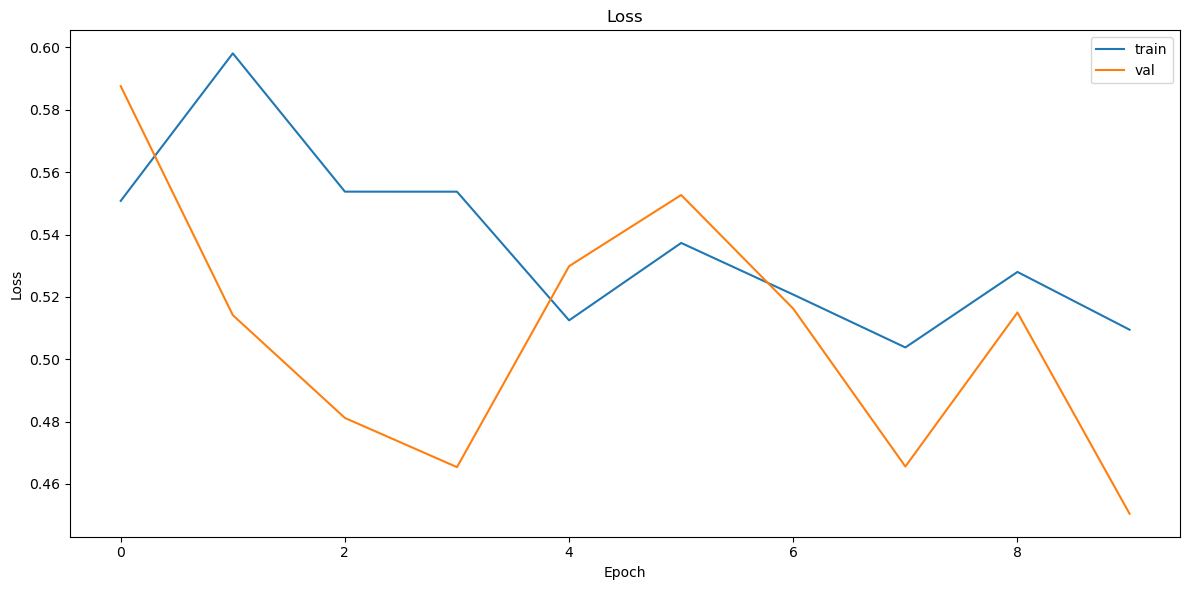

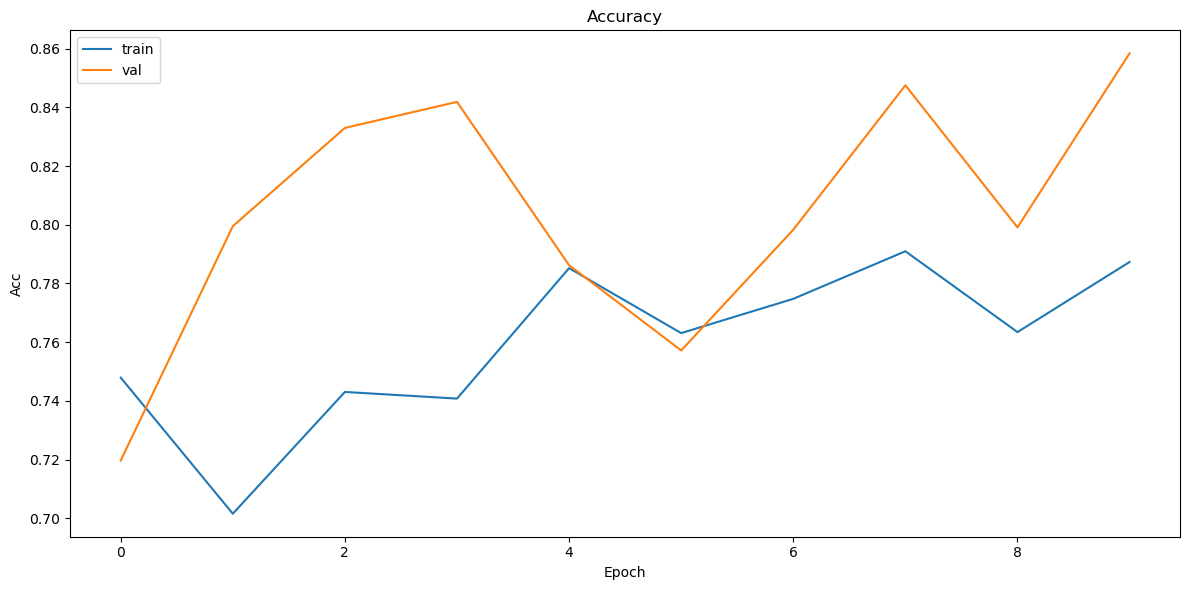

In [29]:
#
# Train2
#
def train2(model, train_dl, val_dl, num_epochs):
    # Loss Function, Optimizer and Scheduler
    CELoss = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=0.005)

    train_loses = []
    val_loses = []
    train_acc = []
    val_acc = []

    def plot_learning():
        plt.figure(figsize=(12, 6))
        plt.title('Loss')
        plt.plot(range(len(train_loses)), train_loses, label='train')
        plt.plot(range(len(val_loses)), val_loses, label='val')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(12, 6))
        plt.title('Accuracy')
        plt.plot(range(len(train_acc)), train_acc, label='train')
        plt.plot(range(len(val_acc)), val_acc, label='val')
        plt.xlabel('Epoch')
        plt.ylabel('Acc')
        plt.legend()
        plt.tight_layout()
        plt.show()


    def run_epoch(is_validate: bool, dl, l_loses, l_acc, log_mode: str):
        running_loss = 0.0
        right_predictions = 0
        all_predictions = 0

        for i, data in enumerate(dl):
            inputs, labels = data[0].to(device), data[1].to(device)

            # Normalize because of BatchNorm layers in model
            inputs_m, inputs_s = inputs.mean(), inputs.std()
            inputs = (inputs - inputs_m) / inputs_s


            # Zero the parameter gradients
            if not is_validate:
                optimizer.zero_grad()

            # forward
            outputs = model(inputs)
            loss = CELoss(outputs, labels)

            if not is_validate:
                # backward + optimize
                loss.backward()
                optimizer.step()

            running_loss += loss.item()
            _, prediction = torch.max(outputs,1)

            right_predictions += (prediction == labels).sum().item()
            all_predictions += prediction.shape[0]

        num_batches = len(dl)
        curr_loss = running_loss / num_batches
        accuracy = right_predictions / all_predictions
        l_loses.append(curr_loss)
        l_acc.append(accuracy)
        return f'{log_mode}: Epoch: {epoch}, Loss: {curr_loss:.2f}, Accuracy: {accuracy:.2f}'



    for epoch in tqdm(range(num_epochs)):
        log_train = run_epoch(is_validate=False, dl=train_dl, l_loses=train_loses, l_acc=train_acc, log_mode='TRAIN')
        with torch.no_grad():
            log_val = run_epoch(is_validate=True, dl=val_dl, l_loses=val_loses, l_acc=val_acc, log_mode='VAL')
        print('\t' + log_train)
        print(log_val)

    print('Finished Training')
    plot_learning()



model4 = CNNClassifier2()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model4 = model4.to(device)

num_epochs=10
train2(model4, dl_train, dl_val, num_epochs)

In [30]:
inference(model4, dl_test)


Accuracy: 0.82, Total items: 2358
Precision: 0.9908088235294118, Recall: 0.5620437956204379


## Результат - Эксперемент 03

Метрика на тестовой выборке упала.
Теперь даже на train у нас нет убывания, то есть мы вообще не обучаемся
Нужно вернуть расписание (даже с банальным линейным расписанием результат будет лучше).
И ```lr``` подобран слишком большой, мы в лоссе перепрыгиваем оптимум
(поэтому и нет убывающего графика лосса, вместо этого он скачет)

## Эксперемент 04

Уменьшим ```lr```:
```lr = 0.002```

Добавим простое Линейное рассписание:
```
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.8, total_iters=6)
```

 10%|█         | 1/10 [00:56<08:24, 56.10s/it]

	TRAIN: Epoch: 0, Loss: 0.50, Accuracy: 0.79
VAL: Epoch: 0, Loss: 0.45, Accuracy: 0.87


 20%|██        | 2/10 [01:54<07:37, 57.20s/it]

	TRAIN: Epoch: 1, Loss: 0.48, Accuracy: 0.82
VAL: Epoch: 1, Loss: 0.43, Accuracy: 0.88


 30%|███       | 3/10 [02:49<06:35, 56.47s/it]

	TRAIN: Epoch: 2, Loss: 0.48, Accuracy: 0.82
VAL: Epoch: 2, Loss: 0.44, Accuracy: 0.87


 40%|████      | 4/10 [03:45<05:37, 56.20s/it]

	TRAIN: Epoch: 3, Loss: 0.47, Accuracy: 0.82
VAL: Epoch: 3, Loss: 0.49, Accuracy: 0.83


 50%|█████     | 5/10 [04:43<04:43, 56.71s/it]

	TRAIN: Epoch: 4, Loss: 0.48, Accuracy: 0.81
VAL: Epoch: 4, Loss: 0.54, Accuracy: 0.77


 60%|██████    | 6/10 [05:46<03:55, 58.98s/it]

	TRAIN: Epoch: 5, Loss: 0.49, Accuracy: 0.80
VAL: Epoch: 5, Loss: 0.55, Accuracy: 0.77


 70%|███████   | 7/10 [07:00<03:11, 63.87s/it]

	TRAIN: Epoch: 6, Loss: 0.48, Accuracy: 0.82
VAL: Epoch: 6, Loss: 0.46, Accuracy: 0.84


 80%|████████  | 8/10 [08:18<02:17, 68.55s/it]

	TRAIN: Epoch: 7, Loss: 0.46, Accuracy: 0.83
VAL: Epoch: 7, Loss: 0.44, Accuracy: 0.87


 90%|█████████ | 9/10 [09:27<01:08, 68.46s/it]

	TRAIN: Epoch: 8, Loss: 0.47, Accuracy: 0.82
VAL: Epoch: 8, Loss: 0.46, Accuracy: 0.85


100%|██████████| 10/10 [10:39<00:00, 63.95s/it]

	TRAIN: Epoch: 9, Loss: 0.48, Accuracy: 0.82
VAL: Epoch: 9, Loss: 0.42, Accuracy: 0.88
Finished Training


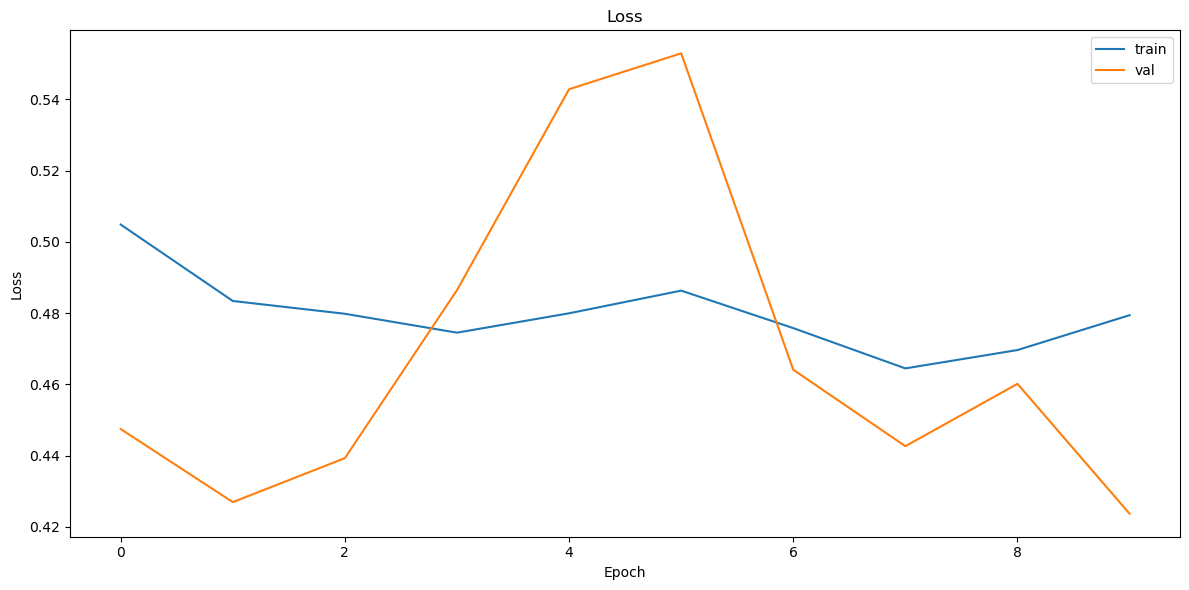

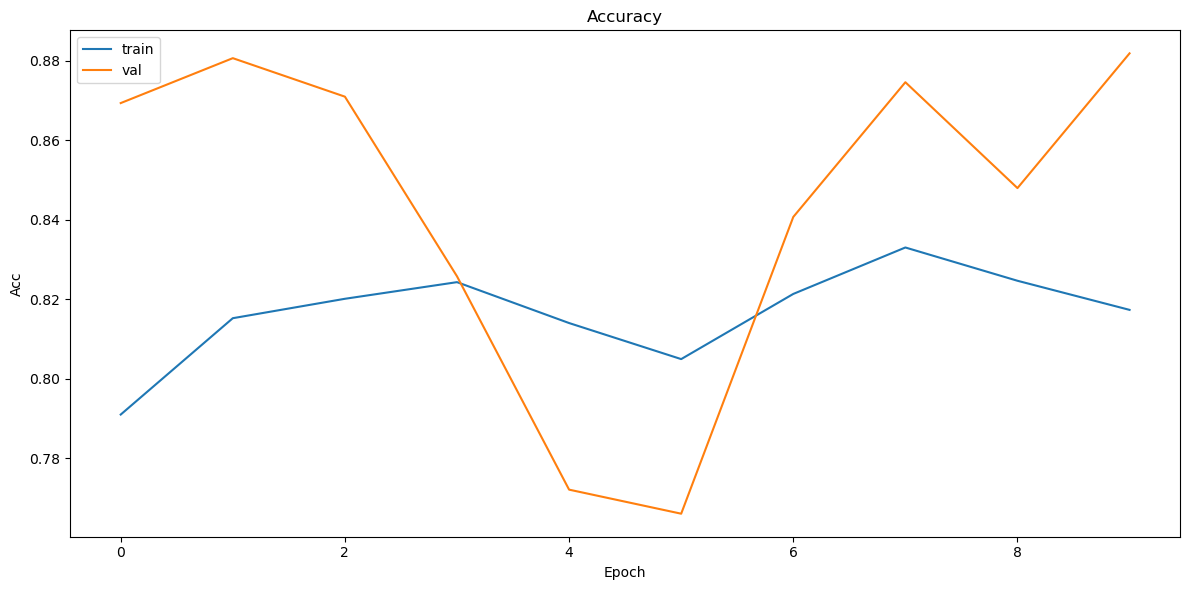

In [31]:
#
# Train3
#
def train3_cheduler_linear(model, train_dl, val_dl, num_epochs, lr=0.001):
    # Loss Function, Optimizer and Scheduler
    CELoss = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=0.002)
    scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.8, total_iters=6)

    train_loses = []
    val_loses = []
    train_acc = []
    val_acc = []

    def plot_learning():
        plt.figure(figsize=(12, 6))
        plt.title('Loss')
        plt.plot(range(len(train_loses)), train_loses, label='train')
        plt.plot(range(len(val_loses)), val_loses, label='val')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(12, 6))
        plt.title('Accuracy')
        plt.plot(range(len(train_acc)), train_acc, label='train')
        plt.plot(range(len(val_acc)), val_acc, label='val')
        plt.xlabel('Epoch')
        plt.ylabel('Acc')
        plt.legend()
        plt.tight_layout()
        plt.show()


    def run_epoch(is_validate: bool, dl, l_loses, l_acc, log_mode: str):
        running_loss = 0.0
        right_predictions = 0
        all_predictions = 0

        for i, data in enumerate(dl):
            inputs, labels = data[0].to(device), data[1].to(device)

            # Normalize because of BatchNorm layers in model
            inputs_m, inputs_s = inputs.mean(), inputs.std()
            inputs = (inputs - inputs_m) / inputs_s


            # Zero the parameter gradients
            if not is_validate:
                optimizer.zero_grad()

            # forward
            outputs = model(inputs)
            loss = CELoss(outputs, labels)

            if not is_validate:
                # backward + optimize
                loss.backward()
                optimizer.step()
                scheduler.step()

            running_loss += loss.item()
            _, prediction = torch.max(outputs,1)

            right_predictions += (prediction == labels).sum().item()
            all_predictions += prediction.shape[0]

        num_batches = len(dl)
        curr_loss = running_loss / num_batches
        accuracy = right_predictions / all_predictions
        l_loses.append(curr_loss)
        l_acc.append(accuracy)
        return f'{log_mode}: Epoch: {epoch}, Loss: {curr_loss:.2f}, Accuracy: {accuracy:.2f}'



    for epoch in tqdm(range(num_epochs)):
        log_train = run_epoch(is_validate=False, dl=train_dl, l_loses=train_loses, l_acc=train_acc, log_mode='TRAIN')
        with torch.no_grad():
            log_val = run_epoch(is_validate=True, dl=val_dl, l_loses=val_loses, l_acc=val_acc, log_mode='VAL')
        print('\t' + log_train)
        print(log_val)

    print('Finished Training')
    plot_learning()



model5 = CNNClassifier2()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model5 = model5.to(device)

num_epochs=10
train3_cheduler_linear(model5, dl_train, dl_val, num_epochs, lr=0.002)

In [32]:
inference(model4, dl_test)

Accuracy: 0.81, Total items: 2358
Precision: 0.9706959706959707, Recall: 0.5526590198123045


## Результат - Эксперемент 04

Расписание улучшило результат по сравнению с экспериментом 03, кажется, что loss на тренировочной
падает, а точность растет. Но осталась проблема с тем, что валидационная выборка колеблется.

По сравнению с первоначальны экспериментом, результат хуже, потому что график не такой гладкий
Нужно вернуться к первоначальному расписанию

## Эксперемент 05 - Уменьшим скорость обучения ```lr``` c 0.001 до 0.0005 и добавим эпох

In [33]:
ds_train = TaskDataset(df_train, data_path)
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=16, shuffle=True)



ds_test = TaskDataset(df_test, data_path)
dl_test = torch.utils.data.DataLoader(ds_test, batch_size=16, shuffle=True)


ds_val = TaskDataset(df_val, data_path)
dl_val = torch.utils.data.DataLoader(ds_val, batch_size=16, shuffle=True)


  5%|▌         | 1/20 [01:03<19:57, 63.03s/it]

	TRAIN: Epoch: 0, Loss: 0.55, Accuracy: 0.75
VAL: Epoch: 0, Loss: 0.45, Accuracy: 0.87


 10%|█         | 2/20 [02:06<18:56, 63.12s/it]

	TRAIN: Epoch: 1, Loss: 0.47, Accuracy: 0.83
VAL: Epoch: 1, Loss: 0.43, Accuracy: 0.88


 15%|█▌        | 3/20 [03:11<18:06, 63.91s/it]

	TRAIN: Epoch: 2, Loss: 0.45, Accuracy: 0.84
VAL: Epoch: 2, Loss: 0.43, Accuracy: 0.88


 20%|██        | 4/20 [04:13<16:51, 63.19s/it]

	TRAIN: Epoch: 3, Loss: 0.45, Accuracy: 0.84
VAL: Epoch: 3, Loss: 0.44, Accuracy: 0.87


 25%|██▌       | 5/20 [05:15<15:41, 62.77s/it]

	TRAIN: Epoch: 4, Loss: 0.43, Accuracy: 0.86
VAL: Epoch: 4, Loss: 0.46, Accuracy: 0.85


 30%|███       | 6/20 [06:16<14:34, 62.45s/it]

	TRAIN: Epoch: 5, Loss: 0.42, Accuracy: 0.88
VAL: Epoch: 5, Loss: 0.50, Accuracy: 0.81


 35%|███▌      | 7/20 [07:19<13:30, 62.32s/it]

	TRAIN: Epoch: 6, Loss: 0.40, Accuracy: 0.90
VAL: Epoch: 6, Loss: 0.45, Accuracy: 0.85


 40%|████      | 8/20 [08:21<12:27, 62.33s/it]

	TRAIN: Epoch: 7, Loss: 0.40, Accuracy: 0.90
VAL: Epoch: 7, Loss: 0.45, Accuracy: 0.86


 45%|████▌     | 9/20 [09:23<11:26, 62.39s/it]

	TRAIN: Epoch: 8, Loss: 0.39, Accuracy: 0.90
VAL: Epoch: 8, Loss: 0.47, Accuracy: 0.85


 50%|█████     | 10/20 [10:26<10:24, 62.48s/it]

	TRAIN: Epoch: 9, Loss: 0.39, Accuracy: 0.90
VAL: Epoch: 9, Loss: 0.55, Accuracy: 0.76


 55%|█████▌    | 11/20 [11:30<09:26, 62.96s/it]

	TRAIN: Epoch: 10, Loss: 0.39, Accuracy: 0.90
VAL: Epoch: 10, Loss: 0.46, Accuracy: 0.85


 60%|██████    | 12/20 [12:34<08:26, 63.33s/it]

	TRAIN: Epoch: 11, Loss: 0.39, Accuracy: 0.91
VAL: Epoch: 11, Loss: 0.45, Accuracy: 0.87


 65%|██████▌   | 13/20 [13:39<07:25, 63.65s/it]

	TRAIN: Epoch: 12, Loss: 0.39, Accuracy: 0.91
VAL: Epoch: 12, Loss: 0.44, Accuracy: 0.87


 70%|███████   | 14/20 [14:43<06:23, 63.93s/it]

	TRAIN: Epoch: 13, Loss: 0.39, Accuracy: 0.91
VAL: Epoch: 13, Loss: 0.46, Accuracy: 0.86


 75%|███████▌  | 15/20 [15:48<05:20, 64.05s/it]

	TRAIN: Epoch: 14, Loss: 0.39, Accuracy: 0.91
VAL: Epoch: 14, Loss: 0.48, Accuracy: 0.84


 80%|████████  | 16/20 [16:52<04:16, 64.17s/it]

	TRAIN: Epoch: 15, Loss: 0.38, Accuracy: 0.91
VAL: Epoch: 15, Loss: 0.47, Accuracy: 0.84


 85%|████████▌ | 17/20 [17:57<03:12, 64.29s/it]

	TRAIN: Epoch: 16, Loss: 0.39, Accuracy: 0.91
VAL: Epoch: 16, Loss: 0.45, Accuracy: 0.86


 90%|█████████ | 18/20 [19:01<02:08, 64.34s/it]

	TRAIN: Epoch: 17, Loss: 0.38, Accuracy: 0.91
VAL: Epoch: 17, Loss: 0.47, Accuracy: 0.84


 95%|█████████▌| 19/20 [20:06<01:04, 64.37s/it]

	TRAIN: Epoch: 18, Loss: 0.38, Accuracy: 0.92
VAL: Epoch: 18, Loss: 0.48, Accuracy: 0.84


100%|██████████| 20/20 [21:10<00:00, 63.52s/it]

	TRAIN: Epoch: 19, Loss: 0.38, Accuracy: 0.92
VAL: Epoch: 19, Loss: 0.48, Accuracy: 0.83
Finished Training


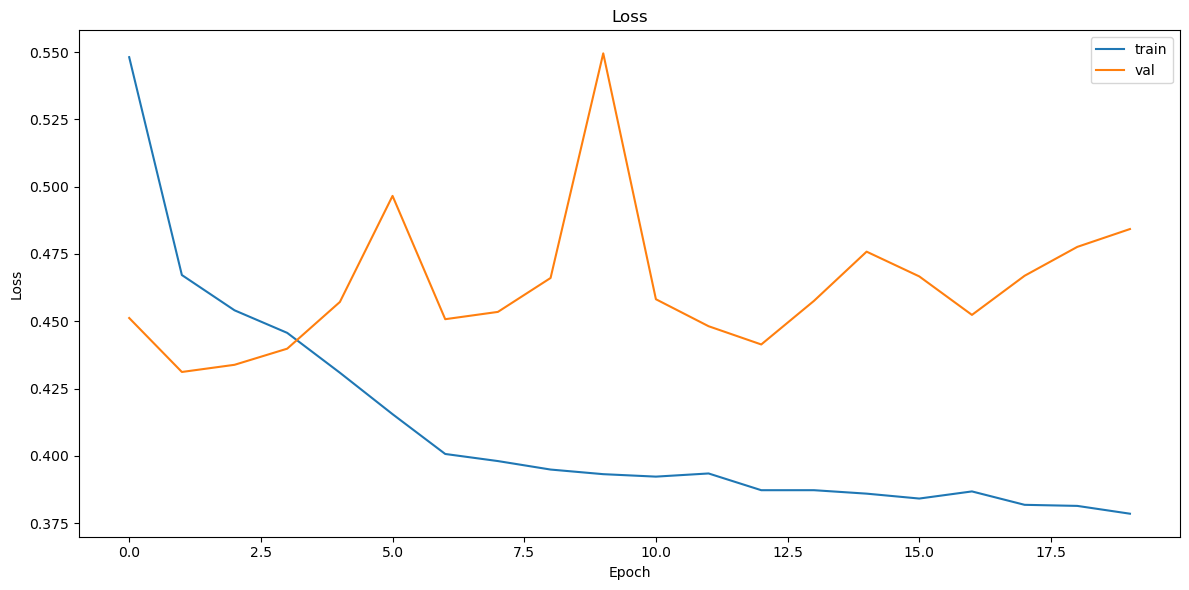

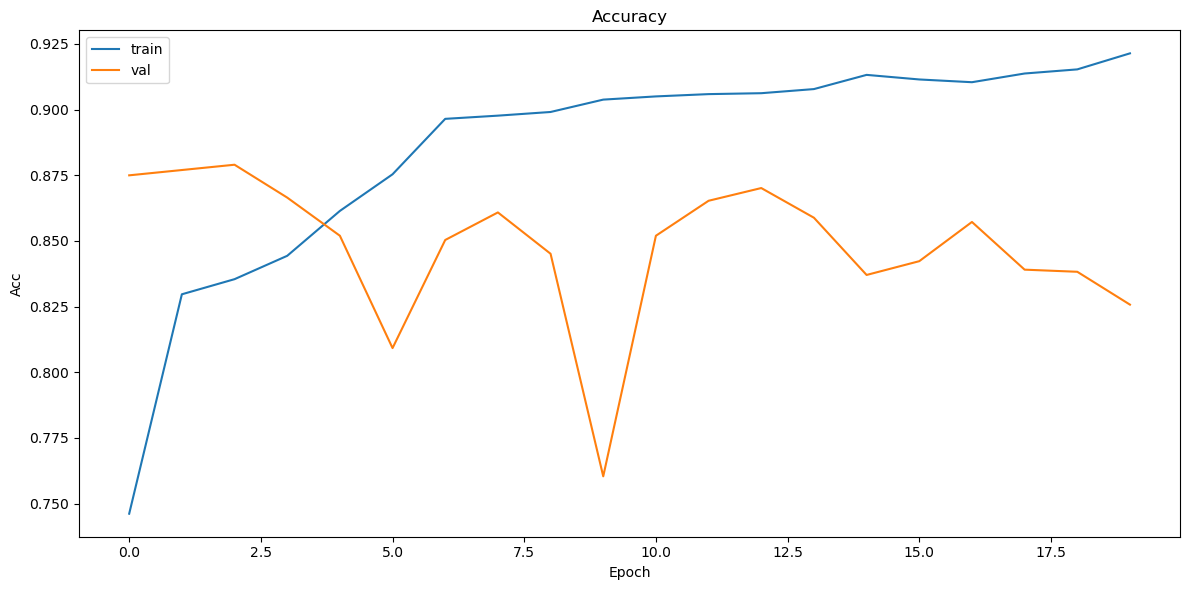

In [34]:
model7 = CNNClassifier()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model7 = model7.to(device)

num_epochs=20
train(model7, dl_train, dl_val, num_epochs, lr=0.0005)


## Эксперемент 05 - Уменьшим скорость обучения ```lr``` c 0.001 до 0.0005 и добавим эпох

Мы переобучились на train, для обучения этой модели
Early stopping нужно было делать в районе 3-5 эпох.


## P.S
Извините за опечатки
